In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import tensorflow as tf

style.use(['ggplot'])

In [4]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 58 (delta 23), reused 41 (delta 18), pack-reused 0
Unpacking objects: 100% (58/58), done.


# Load dataset

In [5]:
train_data = pd.read_json('/content/PhoNER_COVID19/data/word/train_word.json', lines=True)
dev_data = pd.read_json('/content/PhoNER_COVID19/data/word/dev_word.json', lines=True)
test_data = pd.read_json('/content/PhoNER_COVID19/data/word/test_word.json', lines=True)

In [6]:
train_data = train_data.fillna(method='ffill')
dev_data = dev_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')

# Pre-processing

In [7]:
def processing_data(data):
  flat_word = [item for sentence in data['words'] for item in sentence]
  flat_tag = [item for sentence in data['tags'] for item in sentence]
  sentence = []
  for i in range(len(data)):
    for j in range(len(data.iloc[i]['words'])):
        sentence.append("Sentence: "+ str(i+1))

  df = pd.DataFrame(columns=['Sentence #','Word','Tag'])
  df['Sentence #'] = sentence
  df['Word'] = flat_word
  df['Tag'] = flat_tag

  return df

In [8]:
train = processing_data(train_data)
dev = processing_data(dev_data)
test = processing_data(test_data) 

# Word corpus create

In [9]:
corpus = [train['Word'].values.tolist(), dev['Word'].values.tolist(), test['Word'].values.tolist()]
corpus = sum(corpus, [])
corpus[5]

'các'

In [10]:
# tạo tập từ vựng
words = list(set(corpus))
words.append("ENDPAD")
num_words = len(words)

In [11]:
# tạo tập nhãn
tags = list(set(train["Tag"].values))
num_tags = len(tags)

# Get sentences and tag corresponding

In [12]:
def get_sentences(data):
  agg = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),
                                         s["Tag"].values.tolist())]
  group = data.groupby('Sentence #').apply(agg)
  return [sen for sen in group]

In [13]:
sentences = get_sentences(train)

# Mapping sentences and index

In [14]:
word2idx = {w: i   for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
word2idx['ENDPAD']

8101

In [16]:
tag2idx

{'I-ORGANIZATION': 0,
 'I-PATIENT_ID': 1,
 'B-NAME': 2,
 'B-ORGANIZATION': 3,
 'B-PATIENT_ID': 4,
 'B-AGE': 5,
 'B-SYMPTOM_AND_DISEASE': 6,
 'O': 7,
 'I-AGE': 8,
 'I-NAME': 9,
 'B-DATE': 10,
 'B-TRANSPORTATION': 11,
 'I-JOB': 12,
 'I-DATE': 13,
 'B-JOB': 14,
 'B-GENDER': 15,
 'I-SYMPTOM_AND_DISEASE': 16,
 'I-TRANSPORTATION': 17,
 'I-LOCATION': 18,
 'B-LOCATION': 19}

# Visualizing

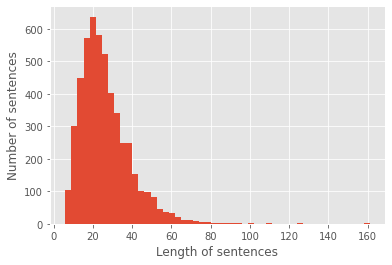

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')

plt.show()

# Padding input

In [18]:
# ánh xạ từ trong câu và nhãn về index của nó
from tensorflow.keras.preprocessing.sequence import pad_sequences
# đặt max length cho phù hợp
max_len = 95

In [19]:
def padding_input(word2idx=word2idx, tag2idx=tag2idx, sentences=sentences, num_words=num_words):
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
  
  #tương tự với nhãn
  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])

  return X, y

In [20]:
X_train, y_train = padding_input()
X_dev, y_dev = padding_input()
X_test, y_test = padding_input()

In [21]:
print(X_train[0])
print(y_train[0])

[2255 4130 6196 1293 5122 6441 7900 6358 2052 6207 6027  378 6609  236
 3743 6956 8033 6098 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


# Building model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [23]:
model = Sequential()

#Input
model.add(Input(shape=(max_len,)))

#Embedding
model.add(Embedding(input_dim=num_words, input_length=max_len, output_dim=max_len))

#SpatialDropout1D
model.add(SpatialDropout1D(0.1))

#LSTM
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5)))

#TimeDistributed
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 95)            769690    
                                                                 
 spatial_dropout1d (SpatialD  (None, 95, 95)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 95, 200)          156800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 95, 20)           4020      
 ibuted)                                                         
                                                                 
Total params: 930,510
Trainable params: 930,510
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Training model

In [25]:
import time
start_time = time.time()

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev,y_dev),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=10,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
158/158 [==============================] - 68s 401ms/step - loss: 0.4363 - accuracy: 0.9356 - val_loss: 0.2175 - val_accuracy: 0.9421
Epoch 2/10
158/158 [==============================] - 63s 400ms/step - loss: 0.1721 - accuracy: 0.9520 - val_loss: 0.1352 - val_accuracy: 0.9597
Epoch 3/10
158/158 [==============================] - 64s 401ms/step - loss: 0.1073 - accuracy: 0.9698 - val_loss: 0.0720 - val_accuracy: 0.9829
Epoch 4/10
158/158 [==============================] - 62s 395ms/step - loss: 0.0581 - accuracy: 0.9857 - val_loss: 0.0393 - val_accuracy: 0.9908
Epoch 5/10
158/158 [==============================] - 62s 395ms/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.0278 - val_accuracy: 0.9929
Epoch 6/10
158/158 [==============================] - 64s 407ms/step - loss: 0.0284 - accuracy: 0.9927 - val_loss: 0.0212 - val_accuracy: 0.9946
Epoch 7/10
158/158 [==============================] - 62s 394ms/step - loss: 0.0227 - accuracy: 0.9940 - val_loss: 0.0172 - val_ac

# Predict

In [26]:
i = 99
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))

1/1 [==============================] - 1s 676ms/step
Word           True 	 Pred

------------------------------
Tôi            O	O
sốt            B-SYMPTOM_AND_DISEASE	B-SYMPTOM_AND_DISEASE
,              O	O
đau            B-SYMPTOM_AND_DISEASE	B-SYMPTOM_AND_DISEASE
họng           I-SYMPTOM_AND_DISEASE	I-SYMPTOM_AND_DISEASE
một_chút       O	O
.              O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD  

# Evaluate model

In [27]:
model.evaluate(X_dev, y_dev)

158/158 [==============================] - 9s 57ms/step - loss: 0.0111 - accuracy: 0.9971


[0.011069844476878643, 0.9971040487289429]

Đánh giá mô hình trên tập dev có giá trị loss = 0.0111 và accuracy = 99.71%.

In [28]:
model.evaluate(X_test, y_test)

158/158 [==============================] - 9s 57ms/step - loss: 0.0111 - accuracy: 0.9971


[0.011069844476878643, 0.9971040487289429]

Đánh giá mô hình trên tập dev có giá trị loss = 0.0111 và accuracy = 99.71%. Mô hình nhận diện rất tốt các vật thể.

# Hoàn thiện yêu cầu của file thực hành

## Accuracy score

In [29]:
predict = np.argmax(model.predict(np.array(X_test)), axis=-1)

158/158 [==============================] - 9s 55ms/step


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.ravel(), predict.ravel())

0.9971040591333117

## F1 score

In [31]:
from sklearn.metrics import  f1_score
print("F1-score (macro): {:.4%}".format(f1_score(y_test.ravel(), predict.ravel(), average = 'macro')))
print("F1-score (micro): {:.4%}".format(f1_score(y_test.ravel(), predict.ravel(), average = 'micro')))

F1-score (macro): 78.7652%
F1-score (micro): 99.7104%


## F1 score và Accuracy score trên từng nhãn cụ thể

In [32]:
from sklearn.metrics import classification_report

idx2tag = {i: t for i, t in enumerate(tags)}

print(classification_report(y_test.ravel(), 
                            predict.ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

       I-ORGANIZATION       0.96      0.96      0.96      2542
         I-PATIENT_ID       0.00      0.00      0.00        11
               B-NAME       0.96      0.94      0.95       348
       B-ORGANIZATION       0.94      0.95      0.95      1135
         B-PATIENT_ID       0.97      1.00      0.98      3220
                B-AGE       0.91      0.95      0.93       682
B-SYMPTOM_AND_DISEASE       0.97      0.97      0.97      1439
                    O       1.00      1.00      1.00    449841
                I-AGE       0.00      0.00      0.00         2
               I-NAME       0.00      0.00      0.00        13
               B-DATE       0.99      0.99      0.99      2549
     B-TRANSPORTATION       0.98      0.95      0.97       226
                I-JOB       0.93      0.44      0.59        62
               I-DATE       0.97      1.00      0.98      2500
                B-JOB       0.85      0.62      0.72  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Lưu lại mô hình và bộ trọng số

In [33]:
from keras.models import save_model
save_model(model, filepath='/content/drive/MyDrive/Colab Notebooks/DS310-NLTK/Buổi 2/lstm_cau_22_BTTH2.h5')